In [1]:
%config Completer.use_jedi=False

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read data & check basic info

In [3]:
df = pd.read_csv('data/LTV.csv')
display(df.head().style.set_caption(f'IBM data for CLTV prediction of shape {df.shape}'))

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
print(df.nunique())

Customer                         9134
State                               5
Customer Lifetime Value          8041
Response                            2
Coverage                            3
Education                           5
Effective To Date                  59
EmploymentStatus                    5
Gender                              2
Income                           5694
Location Code                       3
Marital Status                      3
Monthly Premium Auto              202
Months Since Last Claim            36
Months Since Policy Inception     100
Number of Open Complaints           6
Number of Policies                  9
Policy Type                         3
Policy                              9
Renew Offer Type                    4
Sales Channel                       4
Total Claim Amount               5106
Vehicle Class                       6
Vehicle Size                        3
dtype: int64


In [6]:
display(df.describe())

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


### Check Correlation

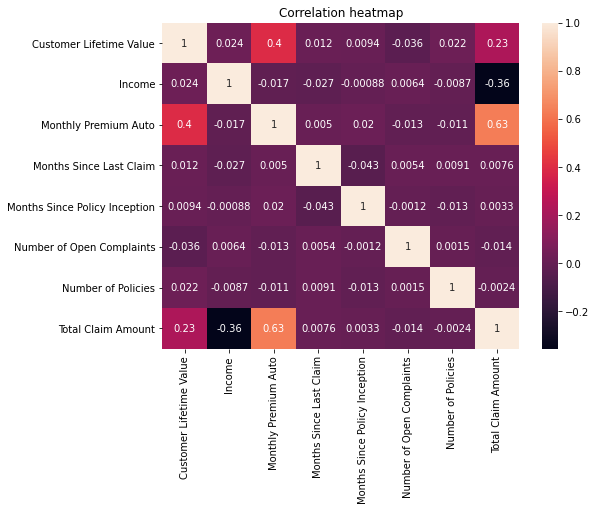

In [7]:
plt.figure(figsize=[8, 6])
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation heatmap')
plt.show()

Можно заметить высокую корреляцию между таргетом и `Monthly Premium Auto`. Отсортирует данные по этому признаку и построим график

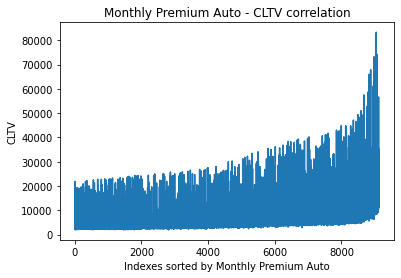

In [8]:
df.sort_values(by=['Monthly Premium Auto'], ascending=True).reset_index()['Customer Lifetime Value'].plot()
plt.title('Monthly Premium Auto - CLTV correlation')
plt.xlabel('Indexes sorted by Monthly Premium Auto')
plt.ylabel('CLTV')
plt.show()

Действительно, в среднем таргет растёт с ростом `Monthly Premium Auto`

### Look at Monthly Premium Auto

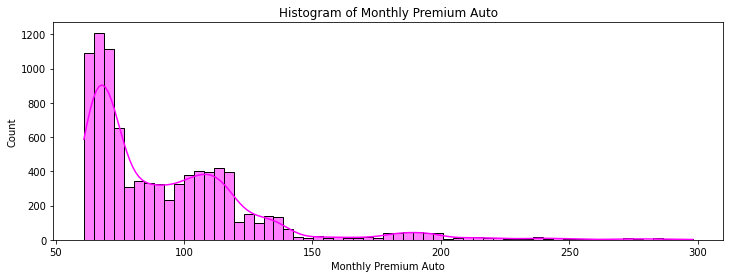

In [8]:
plt.figure(figsize=[12, 4])
sns.histplot(df['Monthly Premium Auto'], color='magenta', kde=True)
plt.title('Histogram of Monthly Premium Auto')
plt.show()

Значения `Monthly Premium Auto` находятся в районе ~60-300, среднее значение ~90

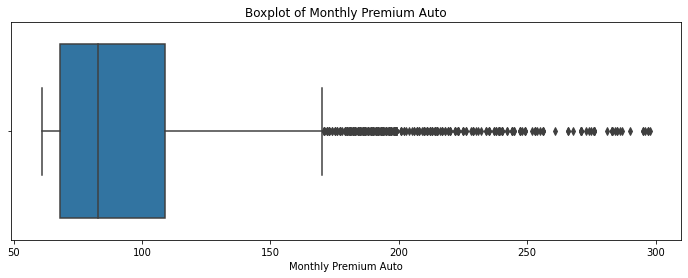

In [9]:
plt.figure(figsize=[12, 4])
sns.boxplot(x=df['Monthly Premium Auto'])
plt.title('Boxplot of Monthly Premium Auto')
plt.show()

Достаточно много выбросов, но в основном они идут более менее непрерывно. Крайне отличающихся единичных выбросов нет

### Look at LTV

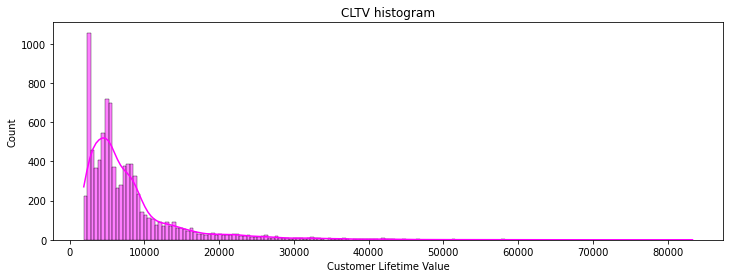

In [10]:
plt.figure(figsize=[12, 4])
sns.histplot(df['Customer Lifetime Value'], color='magenta', kde=True)
plt.title('CLTV histogram')
plt.show()

Среднее значение таргета находится в районе 8000, при этом достаточно много значений находятся между 2000 и 5000

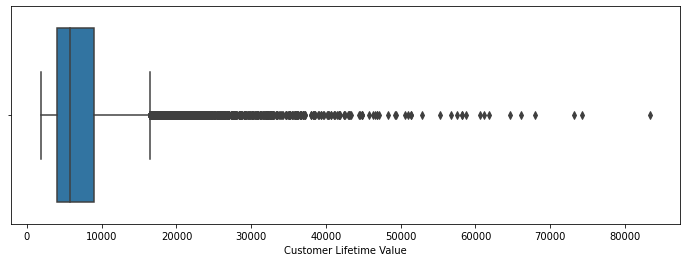

In [11]:
plt.figure(figsize=[12, 4])
sns.boxplot(x=df['Customer Lifetime Value'])
plt.show()

По графику boxplot видно, что таргет имеет достаточно много выбросов, а также совсем экстремально большие значения в 70000-80000, в то время как правая граница "усов" графика находится в районе 16000. 
Для обучения моделей будем использовать логарифм таргета. Редкие большие значения удалим, чтобы модели не сбивались

### Look at LTV for males and females separately

In [12]:
male_df = df.query('Gender == "M"')
female_df = df.query('Gender == "F"')

In [13]:
print('Male max LTV', male_df['Customer Lifetime Value'].max())
print('Male min LTV', male_df['Customer Lifetime Value'].min())
print('Male mean LTV', male_df['Customer Lifetime Value'].mean())

Male max LTV 83325.38119
Male min LTV 1898.007675
Male mean LTV 7909.55148797967


In [14]:
print('Female max LTV', female_df['Customer Lifetime Value'].max())
print('Female min LTV', female_df['Customer Lifetime Value'].min())
print('Female mean LTV', female_df['Customer Lifetime Value'].mean())

Female max LTV 73225.95652
Female min LTV 1898.683686
Female mean LTV 8096.60236975848


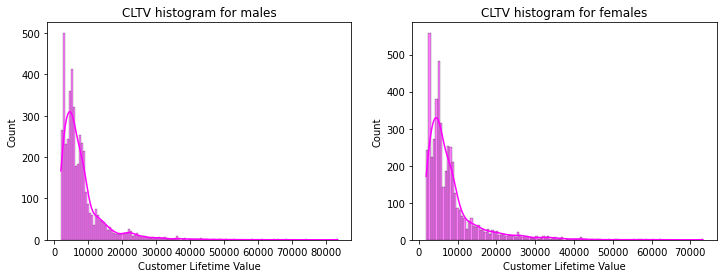

In [15]:
plt.figure(figsize=[12, 4])

plt.subplot(1, 2, 1)
sns.histplot(male_df['Customer Lifetime Value'], color='magenta', kde=True)
plt.title('CLTV histogram for males')

plt.subplot(1, 2, 2)
sns.histplot(female_df['Customer Lifetime Value'], color='magenta', kde=True)
plt.title('CLTV histogram for females')

plt.show()

Максимальные значения LTV находятся среди мужчин, в то время как в среднем женщины тратят чуть больше. Но в целом значения не сильно отличаются от значений общего датасета

### Look at mean CLTV difference between states

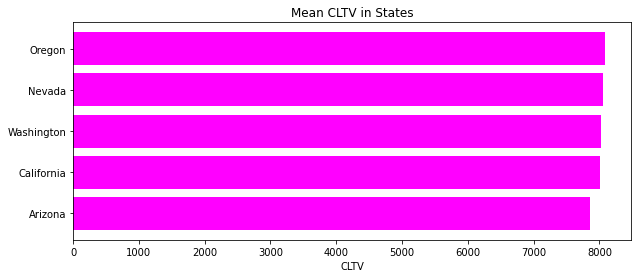

In [17]:
values = df.groupby('State').mean()['Customer Lifetime Value'].values
features = df.groupby('State').mean()['Customer Lifetime Value'].index
indices = np.argsort(values)

plt.figure(figsize=[10, 4])
plt.title('Mean CLTV in States')
plt.barh(range(len(indices)), values[indices], color='magenta', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('CLTV')
plt.show()

Существенной разницы по штатам не наблюдается

### Look at mean CLTV difference between policy types

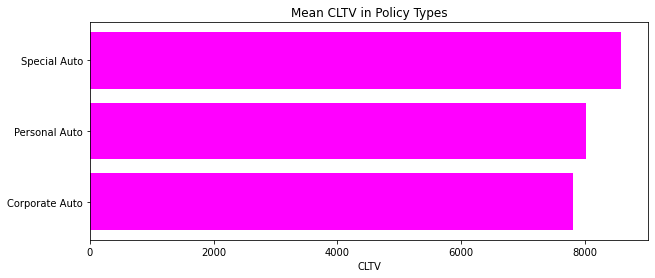

In [20]:
values = df.groupby('Policy Type').mean()['Customer Lifetime Value'].values
features = df.groupby('Policy Type').mean()['Customer Lifetime Value'].index
indices = np.argsort(values)

plt.figure(figsize=[10, 4])
plt.title('Mean CLTV in Policy Types')
plt.barh(range(len(indices)), values[indices], color='magenta', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('CLTV')
plt.show()

### Look at Income

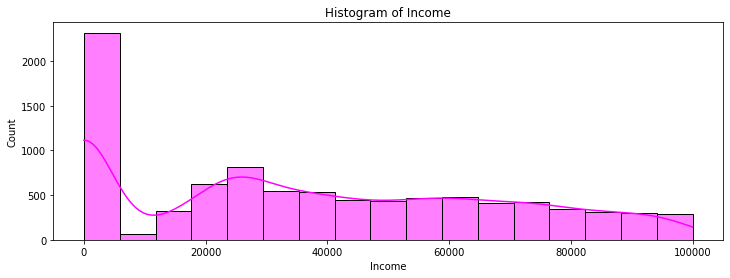

In [16]:
plt.figure(figsize=[12, 4])
sns.histplot(df['Income'], color='magenta', kde=True)
plt.title('Histogram of Income')
plt.show()

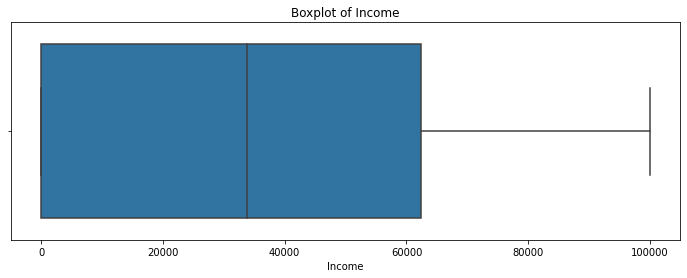

In [17]:
plt.figure(figsize=[12, 4])
sns.boxplot(x=df['Income'])
plt.title('Boxplot of Income')
plt.show()

Достаточно много людей не имеют дохода. Количество людей с разной суммой дохода не равной 0 распределено достаточно равномерно, явных выбросов нет

In [18]:
print(df.query('Income == 0')['EmploymentStatus'].unique())

['Unemployed']


Все, у кого доход равен 0, не устроены на работу

### Look at Effective To Date

In [19]:
df['Effective To Date']

0       2/24/11
1       1/31/11
2       2/19/11
3       1/20/11
4        2/3/11
         ...   
9129    2/10/11
9130    2/12/11
9131     2/6/11
9132     2/3/11
9133    2/14/11
Name: Effective To Date, Length: 9134, dtype: object

In [20]:
print(df['Effective To Date'].apply(lambda x: x.split('/')[2]).unique())

['11']


Все данные по сроку действия страховки датированы 11-ым годом

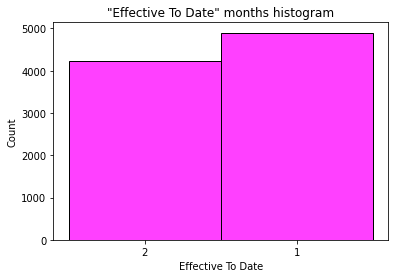

In [21]:
sns.histplot(df['Effective To Date'].apply(lambda x: x.split('/')[0]), color='magenta')
plt.title('"Effective To Date" months histogram')
plt.show()

Данные по месяцам имеют всего 2 уникальных значения

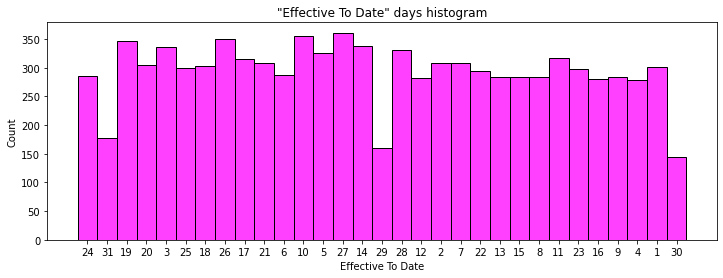

In [22]:
plt.figure(figsize=[12, 4])
sns.histplot(df['Effective To Date'].apply(lambda x: x.split('/')[1]), color='magenta')
plt.title('"Effective To Date" days histogram')
plt.show()

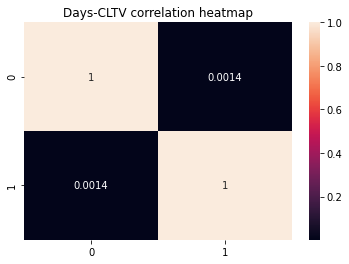

In [23]:
# Посмотрим на корреляцию дней и таргета
sns.heatmap(
    np.corrcoef(df['Effective To Date'].apply(lambda x: int(x.split('/')[1])), df['Customer Lifetime Value']),
    annot=True
)
plt.title('Days-CLTV correlation heatmap')
plt.show()

По дням имеются значения от 1 до 31, но в целом достать какую-то полезную информацию из `Effective To Date` не видится возможным

### Pie Plots

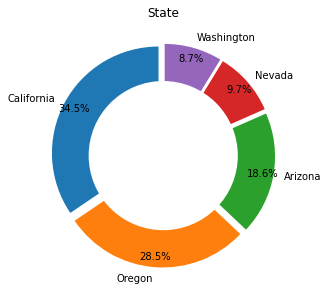

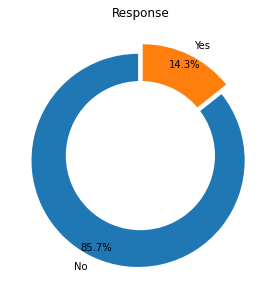

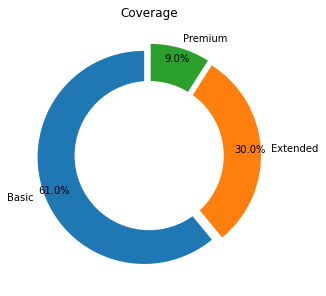

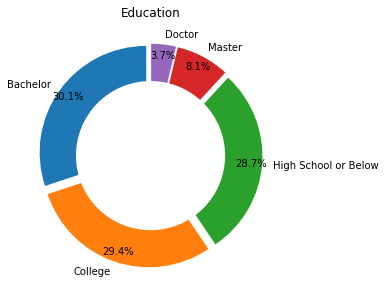

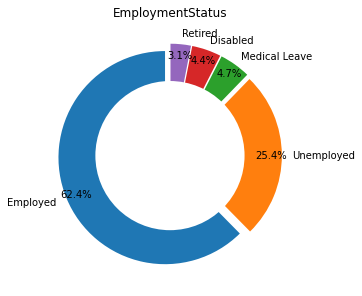

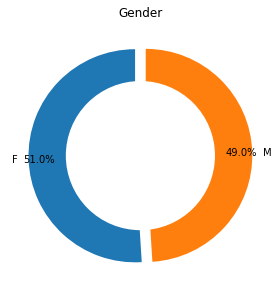

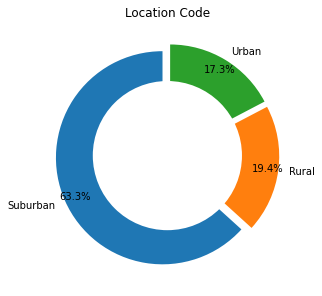

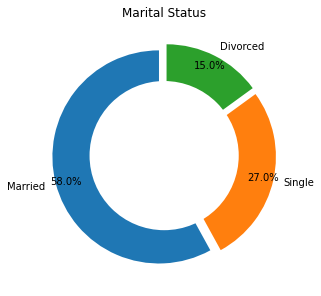

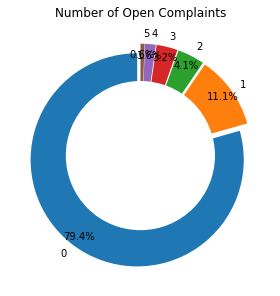

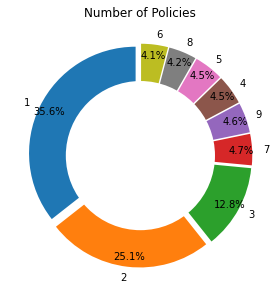

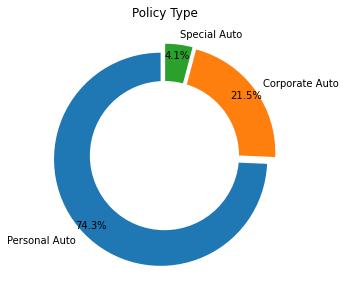

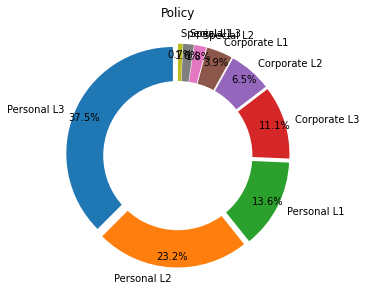

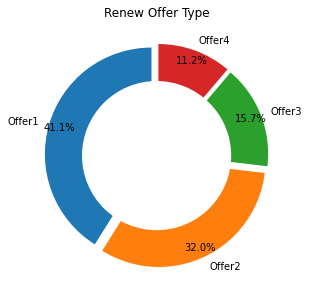

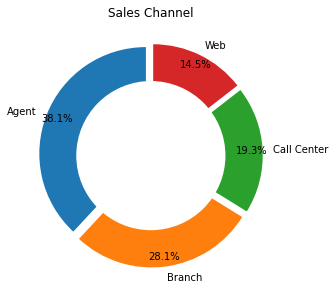

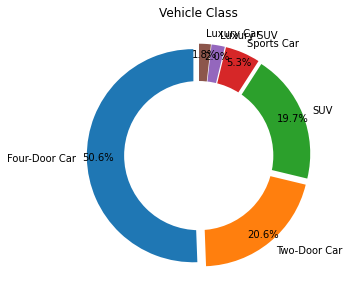

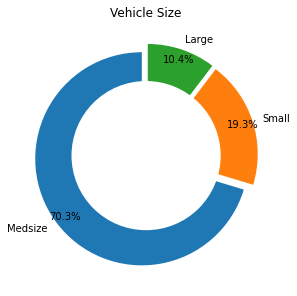

In [24]:
cols = df.columns

for col in cols:
    if df[col].nunique() < 10:
        
        labels = list(df[col].value_counts().index)
        sizes = list(df[col].value_counts())
        explode = (0.05, ) * len(labels)

        plt.pie(sizes, 
                labels=labels, 
                autopct='%1.1f%%', 
                startangle=90, 
                pctdistance=0.9, 
                explode=explode,
                radius=1)
        centre_circle = plt.Circle((0,0) , 0.70, fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.tight_layout()
        plt.title(col)
        plt.show()

По этим диаграммам мы можем наблюдать, как распределены группы внутри признаков в процентах